# *AKU*: Do Predictions

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Tensorflow:", tf.__version__)
print("Keras:", keras.__version__)

Tensorflow: 2.0.0-beta1
Keras: 2.2.4-tf


In [2]:
from dataclasses import dataclass
from io import BytesIO
import json
from pathlib import Path
from typing import Union, List, Dict, Tuple

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import seaborn as sns

from tqdm.auto import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [20]:
sns.set(style='white', context='talk')

In [15]:
# Set to your path
# Note: df will have hard-coded image paths
INDIR = Path("/data", "AKU", "version_2", "tfrecord")
MODEL_DIR = Path("/output")

In [5]:
@dataclass
class ExperimentConfig:
    label_type: str
    min_count: int
        
    def __str__(self):
        return f"ExperimentConfig{{label_type={self.label_type}, min_count={self.min_count}}}"
    
    def __repr(self):
        return self.__str__()
    
    def __hash__(self):
        return hash(self.__str__())

In [6]:
BATCH_SIZE = 128
IMAGE_SIZE = (220, 220)
NUM_CHANNELS = 3

In [7]:
CONFIGS = [
    ExperimentConfig("label", 2),
    ExperimentConfig("label", 10),
    ExperimentConfig("label", 20),
    ExperimentConfig("label", 50),
    ExperimentConfig("category", 2),
    ExperimentConfig("category", 5)
]

## Experiment configuration:
- _V2-AKU_: Version 2 of AKU Dataset
- _220x220_: Image size
- _…_: Network configuration
- _label\_type_: same as above 
- _min\_count_: same as above

In [8]:
# Main Experiment:
EXPERIMENT = "V2-AKU-220x220-C3232P2D-C64C64P2D-F-D256D256D"

In [9]:
def load_image(path: Path):
    
    tiff = Image.open(str(path))
    
    jpeg = BytesIO()
    tiff.save(jpeg, 'JPEG', quality=95)
    
    content = jpeg.getvalue()
    
    image = tf.image.decode_jpeg(content, channels=NUM_CHANNELS)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.abs(image - 255.0)
    image /= 255.0
    
    return image

In [18]:
def get_predictions(config: ExperimentConfig):
    
    exp = f"{EXPERIMENT}_{config.label_type}{config.min_count}"
    
    lbl_enc = joblib.load(str(INDIR.joinpath(f"label-encoder_{config.label_type}{config.min_count}.tar.bz2")))
    data = pd.read_csv(INDIR.joinpath(f"test-split_{config.label_type}{config.min_count}.csv"))
    
    model = keras.models.load_model(str(MODEL_DIR.joinpath(f"{exp}_model.h5")))
    
    y_pred = []
    y_true = []
    
    for _, row in tqdm(data.iterrows(), total=len(data), desc=f"Prediction for '{config.label_type}-{config.min_count}':"):
        
        if config.label_type == 'label':
            y_true.append(row.label)
        elif config.label_type == 'category':
            y_true.append(row.category)
        
        image = tf.expand_dims(load_image(row.image), axis=0)
        prediction = model.predict(image)[0]
        prediction_label_id = tf.argmax(prediction)
        prediction_label_name = lbl_enc.inverse_transform([prediction_label_id])[0]
        y_pred.append(prediction_label_name)
    
    del model
    
    return {'y_pred': y_pred, 'y_true': y_true}

In [19]:
results = {}
for config in CONFIGS:
    results[f"{config.label_type}_{config.min_count}"] = get_predictions(config)

W0710 12:51:16.649251 140295156470272 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
def plot(x, y, name):
    f, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    ax.set_ylabel(name)
    ax.set_xlabel("Experimental Setup")
    
    bars = sns.barplot(x=x, y=y)
    
    sns.despine()
    ax.set_yticks(np.arange(0.0, 1.0, 0.1))
    
    for box in bars.patches:
        height = box.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(box.get_x() + box.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center',
                    va='bottom')
    
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


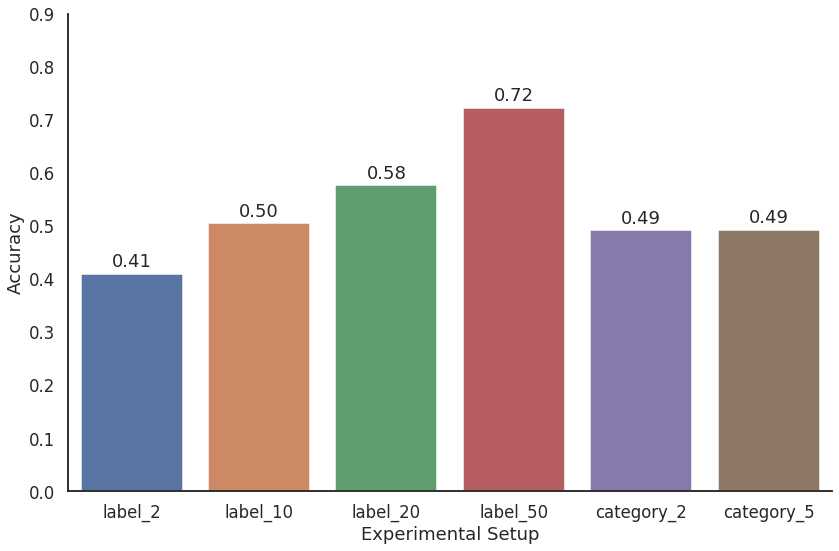

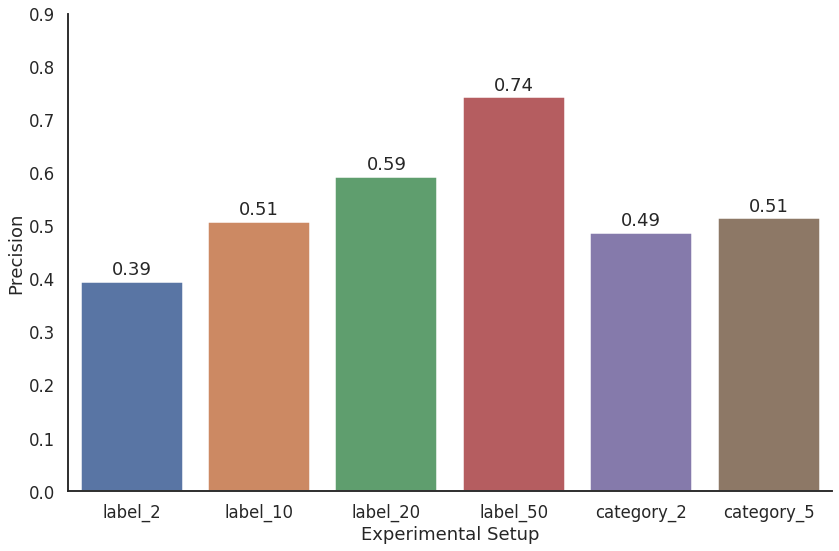

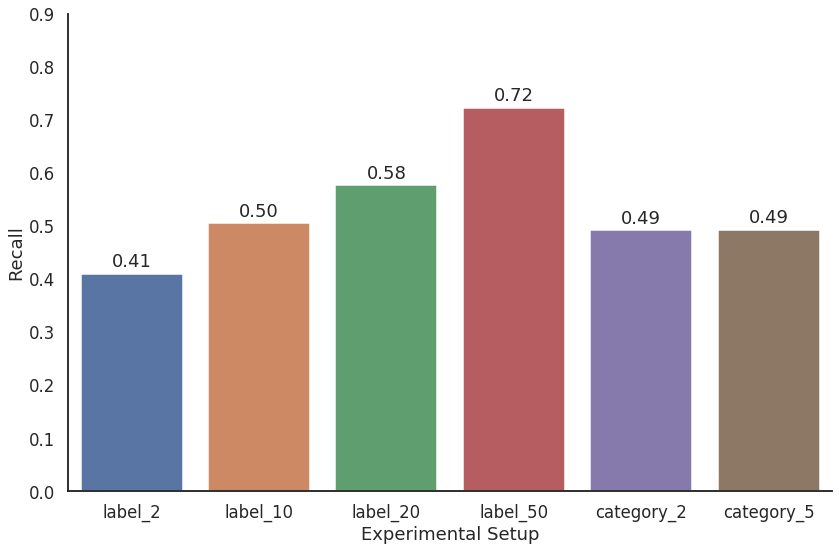

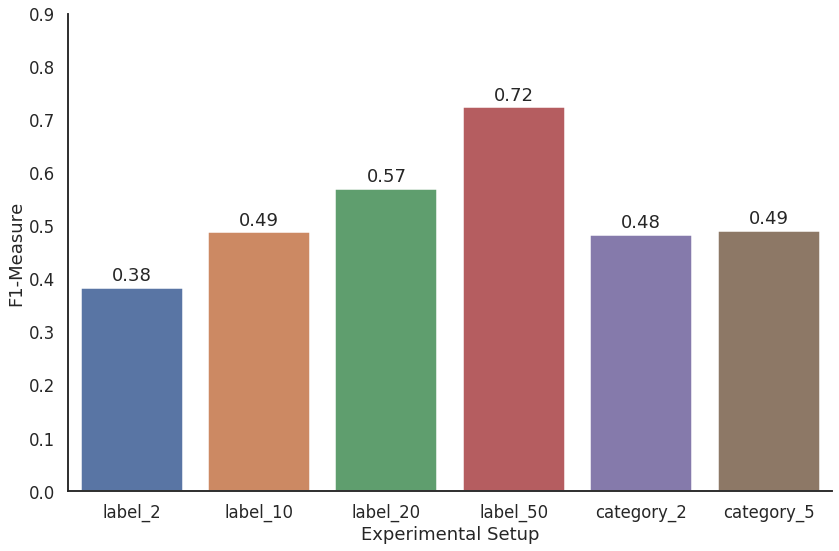

In [22]:
x = np.array(list(results.keys()))

acc = [accuracy_score(v['y_true'], v['y_pred']) for v in results.values()]
prfs = [precision_recall_fscore_support(v['y_true'], v['y_pred'], average='weighted') for v in results.values()]

y_acc = np.array(acc)
y_p = np.array([p for p, _, _, _ in prfs])
y_r = np.array([r for _, r, _, _ in prfs])
y_f = np.array([f for _, _, f, _ in prfs])

plot(x=x, y=y_acc, name="Accuracy")
plot(x=x, y=y_p, name="Precision")
plot(x=x, y=y_r, name="Recall")
plot(x=x, y=y_f, name="F1-Measure")

In [23]:
for exp, res in results.items():
    print("#" * 56)
    print(f"#####ä#### Classification Report for {exp.ljust(8)} #########")
    print("#" * 56)
    print(classification_report(res['y_true'], res['y_pred']))

########################################################
#####ä#### Classification Report for label_2  #########
########################################################
              precision    recall  f1-score   support

        A010       0.47      0.32      0.38        44
        A020       1.00      0.33      0.50         3
        A030       0.56      0.53      0.54        19
        A040       0.50      0.12      0.20         8
        A050       0.67      1.00      0.80         2
        A060       1.00      0.25      0.40         4
        A070       0.44      0.67      0.53         6
        A080       0.62      0.71      0.67         7
        A090       0.00      0.00      0.00         4
        A100       0.57      0.67      0.62         6
        A110       0.33      0.50      0.40         2
        A120       0.00      0.00      0.00         1
        A130       0.00      0.00      0.00         2
        A140       0.00      0.00      0.00         1
        A150       